In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
#from pymer4.models import Lmer
#from pymer4.stats import rsquared, rsquared_adj
import re

In [83]:
inPATH = '../data/training/iapar/cper_biomass_iapar_2014_2022.csv'
inPATH_grazing = '../data/ground/grazing/CARM_ActualGrazingInfov3_2013-2023.csv'

outPATH = '../data/training/iapar/model_selection/cper_biomass_iapar_2014_2022_carm.csv'

In [35]:
df = pd.read_csv(inPATH, parse_dates=True)
df_grazing = pd.read_csv(inPATH_grazing)

In [36]:
df_grazing[df_grazing['PastureCode'] == 'NH'] = '10S'

In [37]:
df

,Year,Pasture,Plot,Id,Treatment,Block,Ecosite,AG,BOBU,C3PG,FORB,SD,WSPG,SS,OTHER,NA,Total_Biomass,Date,iAPAR
0,2013,10S,1,10S_P1,AGM,1.0,Loamy,116.252500,339.062500,363.147500,85.0350,52.340000,83.0175,0.000,0.0,0.0,986.515000,NaN,NaN
1,2013,10S,2,10S_P2,AGM,1.0,Loamy,1.077500,963.910000,31.887500,19.2400,39.287500,0.0000,0.000,0.0,0.0,1016.115000,NaN,NaN
2,2013,10S,3,10S_P3,AGM,1.0,Loamy,0.000000,457.467500,175.317500,0.1900,11.705000,18.4325,0.000,0.0,0.0,651.407500,NaN,NaN
3,2013,10S,4,10S_P4,AGM,1.0,Loamy,62.295000,507.520000,79.652500,123.7850,13.455000,0.0000,0.000,0.0,0.0,773.252500,NaN,NaN
4,2013,15E,1,15E_P1,TGM,1.0,Loamy,57.586667,507.696667,13.993333,59.9200,7.176667,0.0000,0.000,0.0,0.0,639.196667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,2022,7SE,6,7SE_P6,AGM,7.0,Salt Flats,0.000000,15.607500,164.865000,125.6025,70.397500,74.4575,126.355,0.0,0.0,380.532500,2022-08-04,44.869000
988,2022,8E,1,8E_P1,AGM,8.0,Loamy,0.000000,110.990000,94.265000,33.7575,173.260000,0.0000,0.000,0.0,0.0,239.012500,2022-08-03,35.033633
989,2022,8E,2,8E_P2,AGM,8.0,Sandy,0.000000,216.720000,44.550000,46.3400,213.650000,5.6100,0.000,0.0,0.0,313.220000,2022-08-03,28.615596
990,2022,8E,3,8E_P3,AGM,8.0,Loamy,0.000000,266.165000,182.610000,0.4450,286.105000,0.0000,0.000,0.0,0.0,449.220000,2022-08-03,34.198077


In [38]:
df = df.dropna(subset=['Date', 'Total_Biomass', 'iAPAR']).copy().reset_index()

In [39]:
df

,index,Year,Pasture,Plot,Id,Treatment,Block,Ecosite,AG,BOBU,C3PG,FORB,SD,WSPG,SS,OTHER,NA,Total_Biomass,Date,iAPAR
0,92,2014,10S,1,10S_P1,AGM,1.0,Loamy,564.4325,222.0050,201.5550,847.3900,40.6350,186.0800,111.9450,0.0,0.0,2021.4625,2014-08-04,123.495323
1,93,2014,10S,2,10S_P2,AGM,1.0,Loamy,235.5950,803.1250,31.2150,322.6475,14.2600,6.1900,0.0000,0.0,0.0,1398.7725,2014-08-04,152.910320
2,94,2014,10S,3,10S_P3,AGM,1.0,Loamy,8.8800,694.6775,250.1275,144.9075,34.7125,0.0000,0.0000,0.0,0.0,1098.5925,2014-08-04,164.764037
3,95,2014,10S,4,10S_P4,AGM,1.0,Loamy,390.3250,460.4250,16.1475,684.8550,45.7450,0.0000,0.0000,0.0,0.0,1551.7525,2014-08-04,159.652053
4,96,2014,15E,1,15E_P1,TGM,1.0,Loamy,571.7000,511.4225,35.5200,40.6325,46.0125,4.5750,85.9775,0.0,0.0,1163.8500,2014-08-04,103.124891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,987,2022,7SE,6,7SE_P6,AGM,7.0,Salt Flats,0.0000,15.6075,164.8650,125.6025,70.3975,74.4575,126.3550,0.0,0.0,380.5325,2022-08-04,44.869000
896,988,2022,8E,1,8E_P1,AGM,8.0,Loamy,0.0000,110.9900,94.2650,33.7575,173.2600,0.0000,0.0000,0.0,0.0,239.0125,2022-08-03,35.033633
897,989,2022,8E,2,8E_P2,AGM,8.0,Sandy,0.0000,216.7200,44.5500,46.3400,213.6500,5.6100,0.0000,0.0,0.0,313.2200,2022-08-03,28.615596
898,990,2022,8E,3,8E_P3,AGM,8.0,Loamy,0.0000,266.1650,182.6100,0.4450,286.1050,0.0000,0.0000,0.0,0.0,449.2200,2022-08-03,34.198077


In [40]:
df_grazing_in = pd.merge(df, df_grazing[['PastureCode', 'Year', 'DateInPasture']],
         left_on=['Pasture', 'Year'],
         right_on=['PastureCode', 'Year'],
         how='left')

In [41]:
df_grazing_in = df_grazing_in.set_index('index')

In [42]:
df = df.set_index('index')

In [43]:
df['DateInPasture'] = df_grazing_in.drop_duplicates(subset=['Id', 'Year'], keep='first')['DateInPasture']

In [44]:
df['DateInPasture'] = pd.to_datetime(df['DateInPasture'])

In [45]:
df['Date'] = pd.to_datetime(df['Date'])

In [46]:
def calc_graze_timing(x):
    if x['Treatment'] in ['TGM', 'NEW_HVY']:
            timing = 'Season-long'
    else:
        if pd.isnull(x['DateInPasture']):
            timing = 'Ungrazed'
        elif x['DateInPasture'] > x['Date']:
            timing = 'Ungrazed'
        elif x['DateInPasture'].dayofyear > 196:
            timing = 'Ungrazed'
        elif x['DateInPasture'].dayofyear <= 196:
            timing = 'Pulse'
    return timing
        

In [47]:
df['Graze_timing'] = df.apply(lambda x: calc_graze_timing(x), axis=1)

In [48]:
df["Total_Biomass_sqrt"] = np.sqrt(df['Total_Biomass'])
df['Block'] = df['Block'].astype(int).astype(str)

In [49]:
df['Ecosite'] = pd.Categorical(df['Ecosite'],
                               categories=['Loamy', 'Sandy', 'Salt Flats'])
df['Graze_timing'] = pd.Categorical(df['Graze_timing'],
                               categories=['Ungrazed', 'Season-long', 'Pulse'])

In [50]:
df['Graze_timing'].value_counts()

Season-long    474
Ungrazed       246
Pulse          180
Name: Graze_timing, dtype: int64

In [51]:
df_sub = df[df['Treatment'].isin(['TGM', 'AGM'])].copy()

In [67]:
df_sub.groupby(['Id'])['Year'].count().index[df_sub.groupby(['Id'])['Year'].count().values < 9]

Index(['18S_P5', '18S_P6', '19N_P5', '19N_P6'], dtype='object', name='Id')

In [74]:
df_sub.groupby(['Pasture', 'Graze_timing'])['Year'].apply(lambda x: int(len(x.unique())))

Pasture  Graze_timing
10S      Ungrazed        9.0
         Season-long     NaN
         Pulse           NaN
15E      Ungrazed        NaN
         Season-long     9.0
         Pulse           NaN
17N      Ungrazed        NaN
         Season-long     9.0
         Pulse           NaN
17S      Ungrazed        5.0
         Season-long     NaN
         Pulse           4.0
18S      Ungrazed        3.0
         Season-long     NaN
         Pulse           6.0
19N      Ungrazed        NaN
         Season-long     9.0
         Pulse           NaN
20NW     Ungrazed        3.0
         Season-long     NaN
         Pulse           6.0
20SE     Ungrazed        NaN
         Season-long     9.0
         Pulse           NaN
21N      Ungrazed        5.0
         Season-long     NaN
         Pulse           4.0
24W      Ungrazed        NaN
         Season-long     9.0
         Pulse           NaN
25NW     Ungrazed        6.0
         Season-long     NaN
         Pulse           3.0
25SE     Ungrazed    

In [84]:
df_sub.to_csv(outPATH, index=False)

<Figure size 432x288 with 0 Axes>

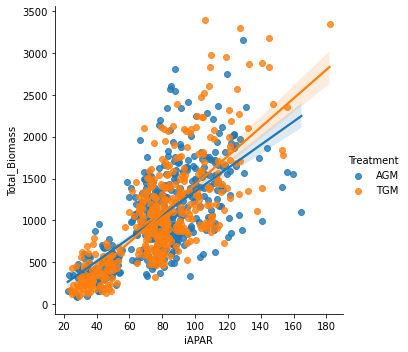

In [77]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Treatment', ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

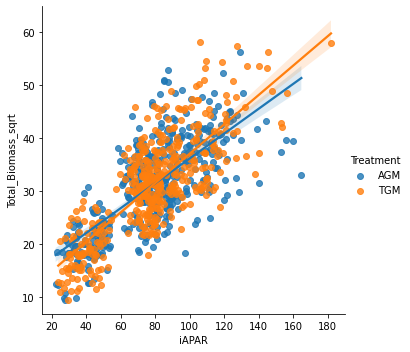

In [78]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

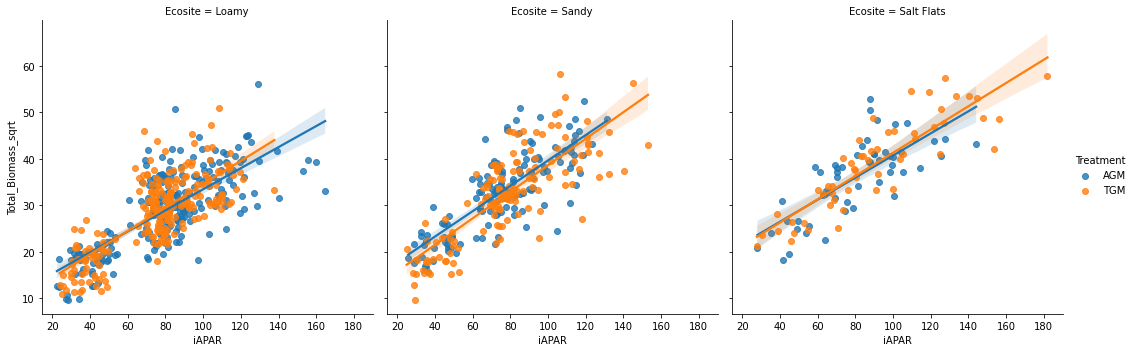

In [79]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Ecosite', ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

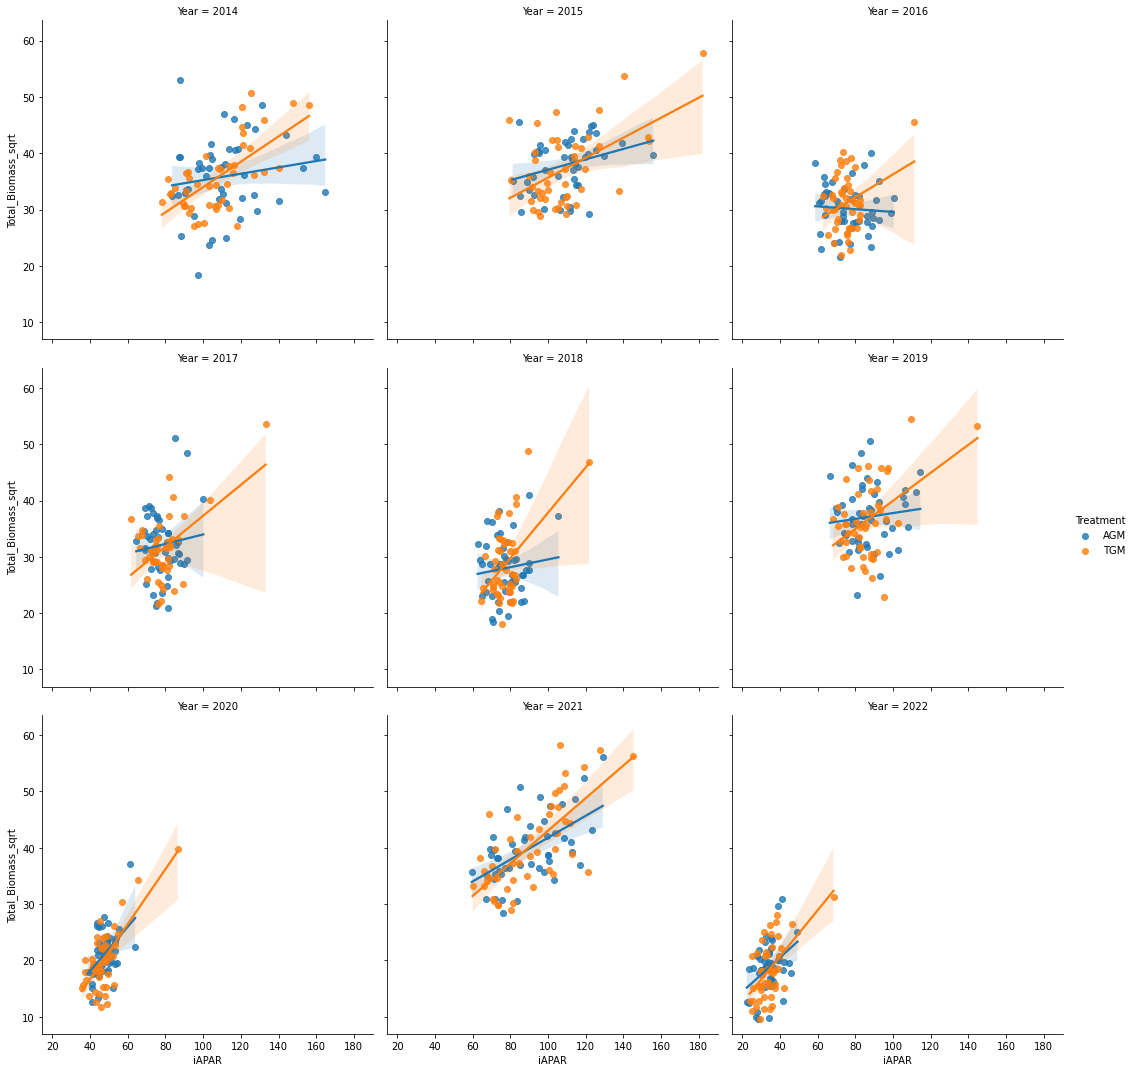

In [80]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Year', col_wrap=3, ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

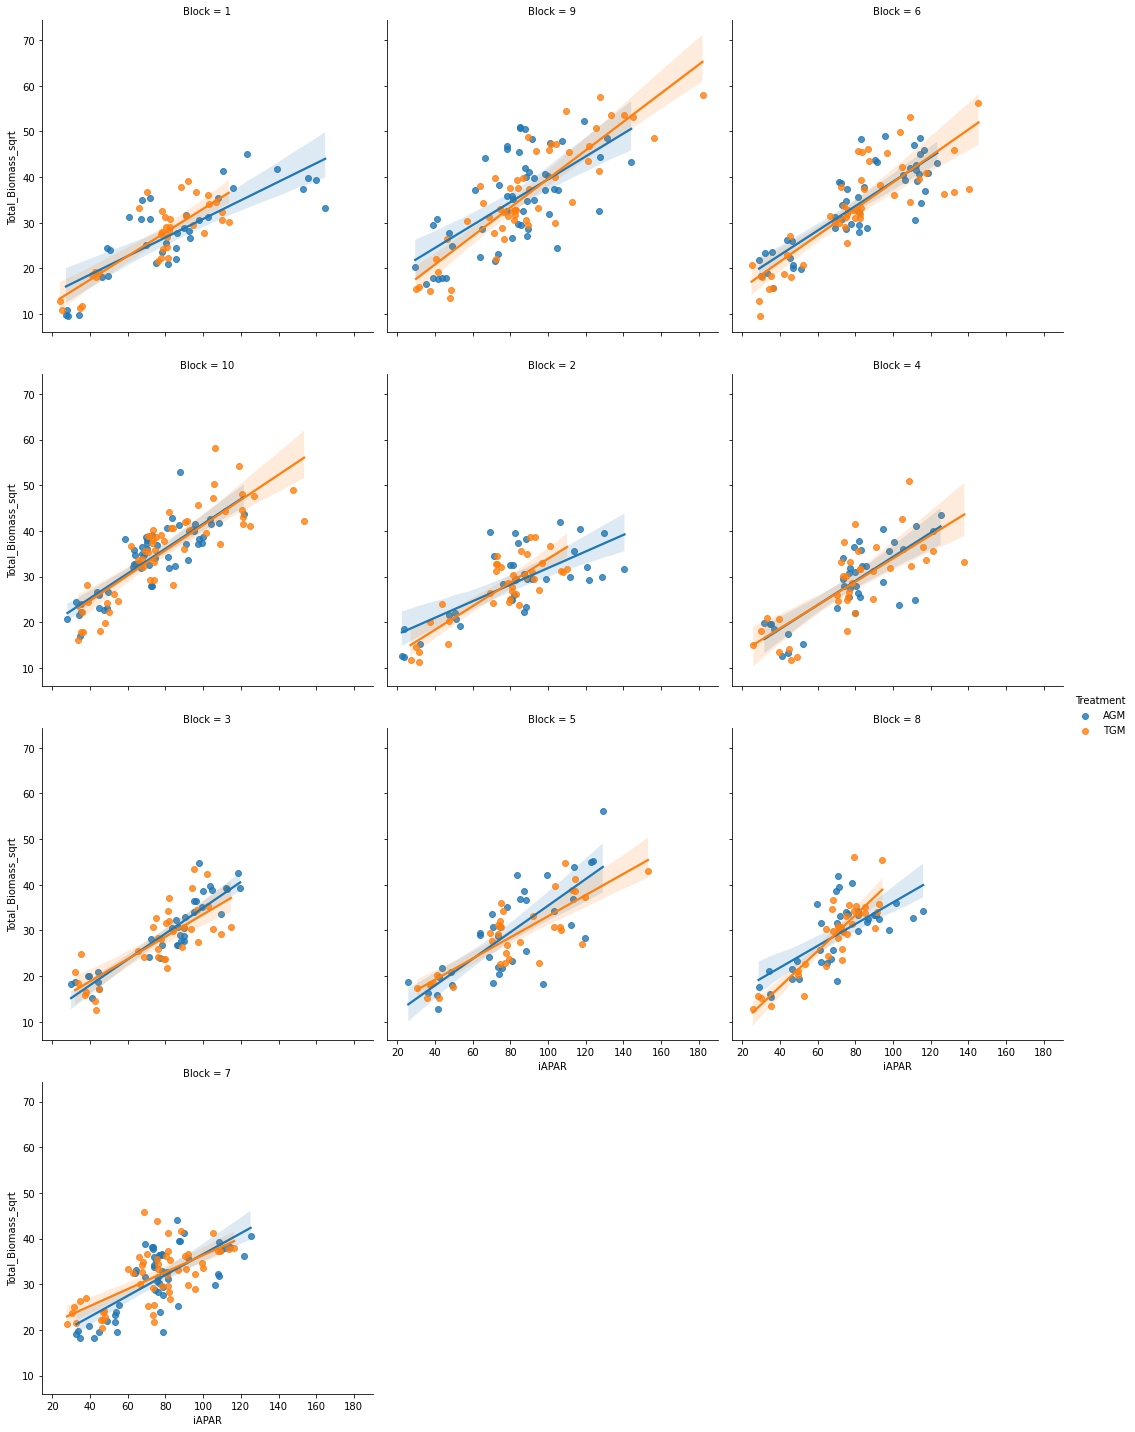

In [81]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Treatment', col='Block', col_wrap=3, ci=95, 
           data=df_sub)
plt.show()

<Figure size 432x288 with 0 Axes>

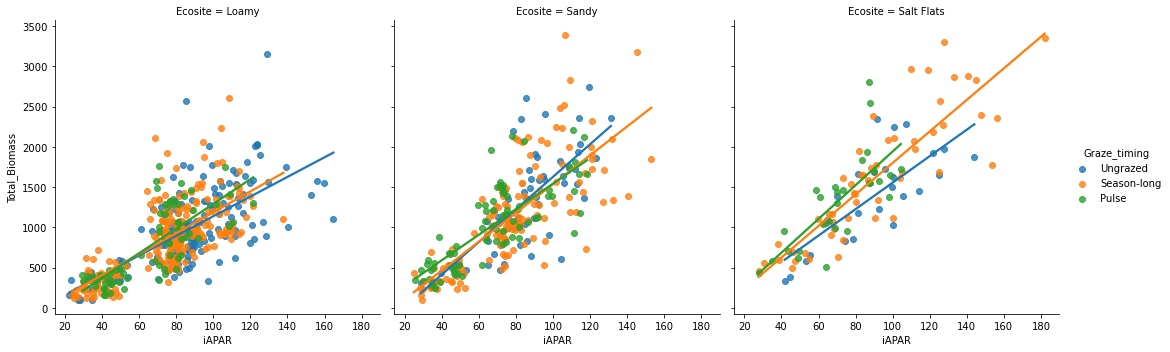

In [82]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', col='Ecosite', ci=None, 
           data=df_sub)
plt.show()

/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

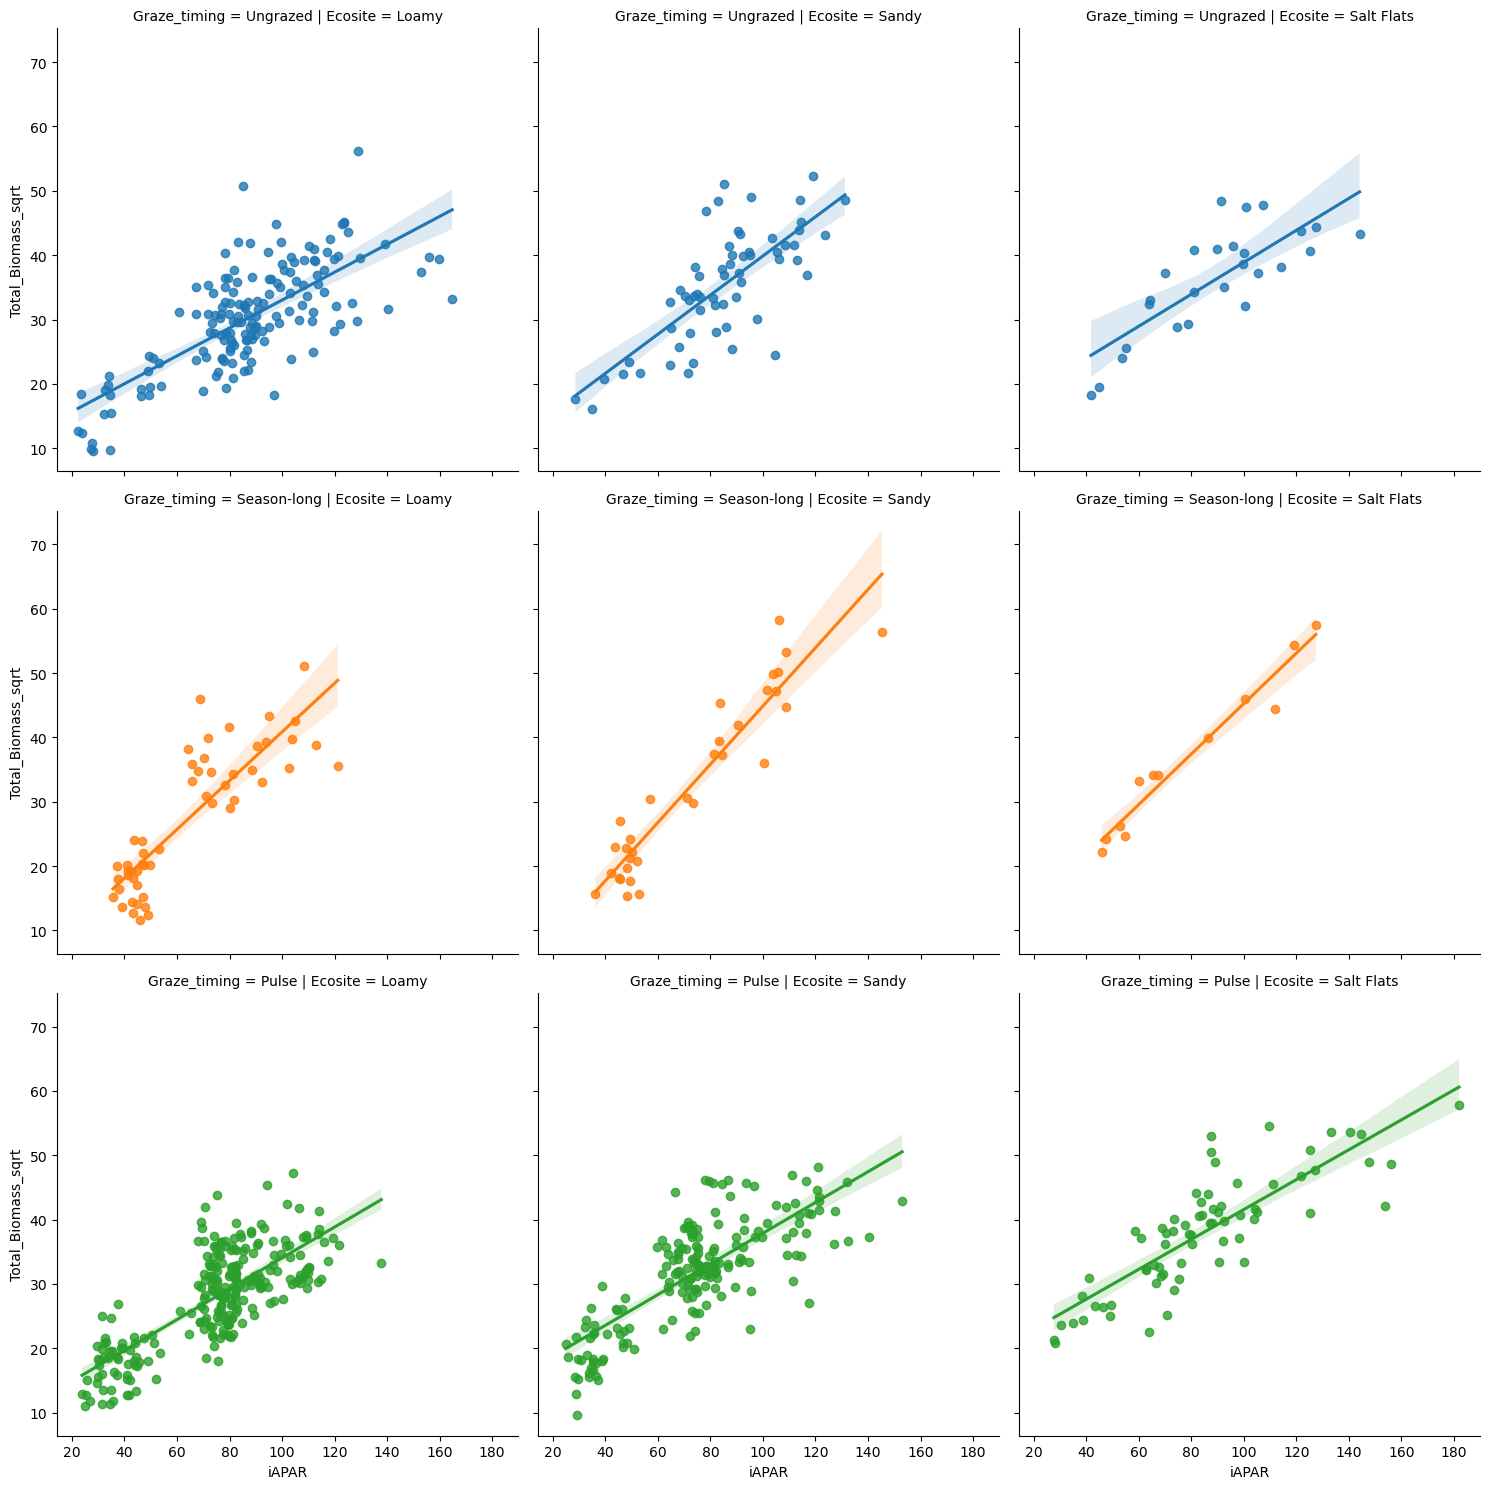

In [34]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass_sqrt', hue='Graze_timing', col='Ecosite', row='Graze_timing', ci=95, 
           data=df_sub)
plt.show()

In [35]:
# fit the null model, single slope for iAPAR
# NOTE: tried adding + (1|Block:Pasture) to account for pasture effect, but fit was singular and effect was 0
md_mm_orig = Lmer('Total_Biomass ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_orig.fit())

md_mm_sqrt = Lmer('Total_Biomass_sqrt ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_sqrt.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6154.010 	 AIC: 12318.021

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43744.979  209.153
Year        (Intercept)  37028.078  192.427
Residual                 91447.762  302.403

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-49.559,-245.67,146.551,100.058,28.456,-0.495,0.624,
iAPAR,13.678,11.86,15.497,0.928,435.994,14.744,0.000,***


Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass_sqrt~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -2536.228 	 AIC: 5082.455

Random effects:

                   Name     Var    Std
Year:Block  (Intercept)  10.424  3.229
Year        (Intercept)  14.029  3.746
Residual                 18.001  4.243

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),16.817,13.534,20.100,1.675,19.263,10.041,0.0,***
iAPAR,0.177,0.150,0.203,0.013,660.113,13.168,0.0,***


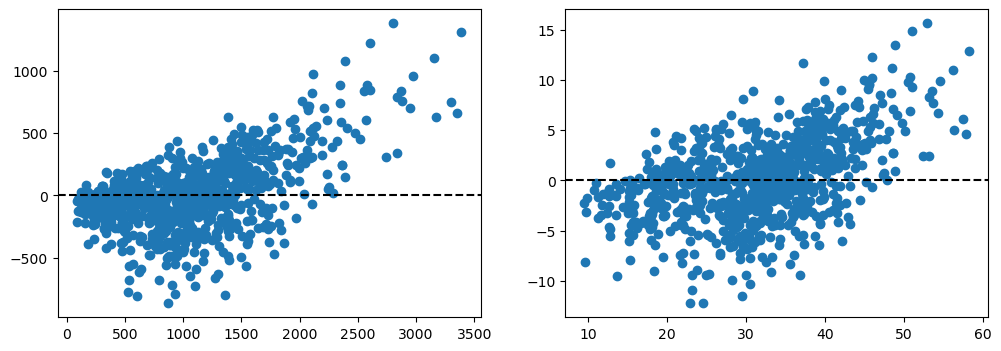

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], md_mm_orig.residuals)
axs[1].scatter(df_sub['Total_Biomass_sqrt'], md_mm_sqrt.residuals)
for ax in axs:
    ax.axhline(y=0, linestyle='dashed', c='black')

(array([  8.,  25.,  99., 201., 257., 151.,  76.,  25.,   6.,   4.]),
 array([-12.2179861 ,  -9.43346595,  -6.64894579,  -3.86442564,
         -1.07990549,   1.70461467,   4.48913482,   7.27365497,
         10.05817513,  12.84269528,  15.62721543]),
 <BarContainer object of 10 artists>)

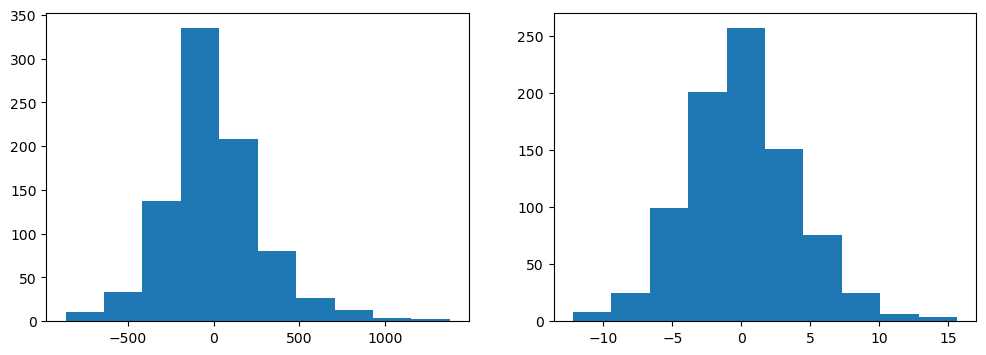

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].hist(md_mm_orig.residuals)
axs[1].hist(md_mm_sqrt.residuals)

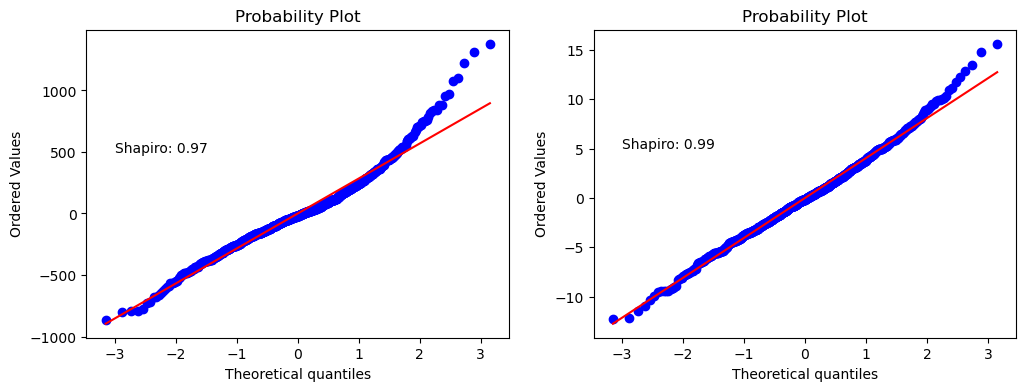

In [38]:
from scipy.stats import shapiro, probplot
import pylab


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
probplot(md_mm_orig.residuals, dist="norm", plot=axs[0])
axs[0].text(-3, 500, 'Shapiro: ' + str(round(shapiro(md_mm_orig.residuals).statistic, 2)))
probplot(md_mm_sqrt.residuals, dist="norm", plot=axs[1])
axs[1].text(-3, 5, 'Shapiro: ' + str(round(shapiro(md_mm_sqrt.residuals).statistic, 2)))
plt.show()

In [39]:
y_var = 'Total_Biomass'
#axlims = (-0.25, 0.25)
axlims = (-5, 16)

In [40]:
# fit the null model, single slope for iAPAR
# NOTE: tried adding + (1|Block:Pasture) to account for pasture effect, but fit was singular and effect was 0
md_mm_null = Lmer(y_var + ' ~ iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_null.fit())

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6154.010 	 AIC: 12318.021

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43744.979  209.153
Year        (Intercept)  37028.078  192.427
Residual                 91447.762  302.403

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-49.559,-245.67,146.551,100.058,28.456,-0.495,0.624,
iAPAR,13.678,11.86,15.497,0.928,435.994,14.744,0.000,***


Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Treatment:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6153.754 	 AIC: 12319.508

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  43571.777  208.739
Year        (Intercept)  36995.508  192.342
Residual                 91427.632  302.370

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-50.169,-246.198,145.859,100.016,28.469,-0.502,0.62,
iAPAR,13.537,11.704,15.369,0.935,443.735,14.478,0.00,***
iAPAR:TreatmentTGM,0.301,-0.190,0.793,0.251,763.257,1.201,0.23,


<Axes: xlabel='Estimate'>

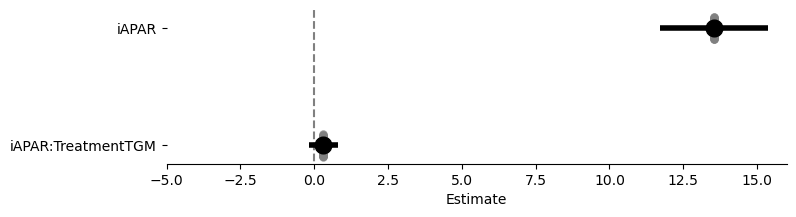

In [41]:
md_mm_treatment = Lmer(y_var + ' ~ iAPAR + Treatment:iAPAR  + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_treatment.fit())
md_mm_treatment.plot_summary(plot_intercept=False, figsize=(8, 2), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Graze_timing:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6148.747 	 AIC: 12311.493

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  41319.474  203.272
Year        (Intercept)  35281.697  187.834
Residual                 90967.358  301.608

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-82.108,-277.054,112.838,99.464,29.403,-0.826,0.416,
iAPAR,13.487,11.674,15.300,0.925,416.368,14.582,0.000,***
iAPAR:Graze_timingSeason-long,1.348,0.191,2.504,0.590,771.920,2.284,0.023,*
iAPAR:Graze_timingPulse,0.836,0.208,1.464,0.320,836.709,2.608,0.009,**


<Axes: xlabel='Estimate'>

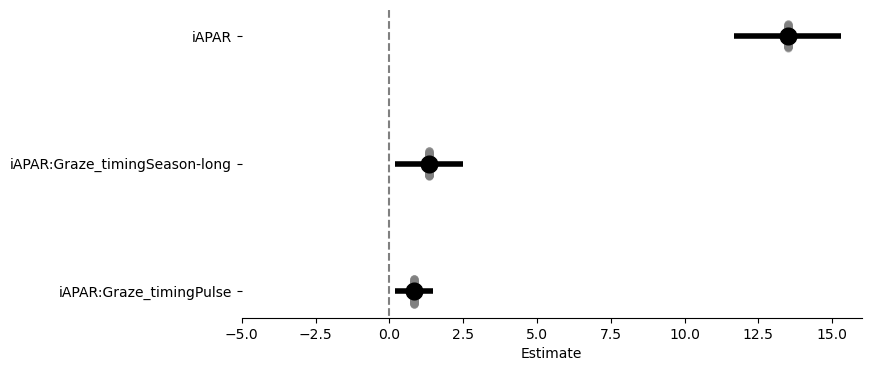

In [42]:
md_mm_graze = Lmer(y_var + ' ~ iAPAR + Graze_timing:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_graze.fit())
md_mm_graze.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Ecosite:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6086.391 	 AIC: 12186.782

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  13868.121  117.763
Year        (Intercept)  51673.454  227.318
Residual                 83752.834  289.401

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),173.026,-32.651,378.702,104.939,22.703,1.649,0.113,
iAPAR,9.470,7.658,11.281,0.924,504.333,10.248,0.000,***
iAPAR:EcositeSandy,2.736,2.067,3.405,0.341,393.929,8.016,0.000,***
iAPAR:EcositeSalt Flats,5.366,4.558,6.174,0.412,686.040,13.015,0.000,***


<Axes: xlabel='Estimate'>

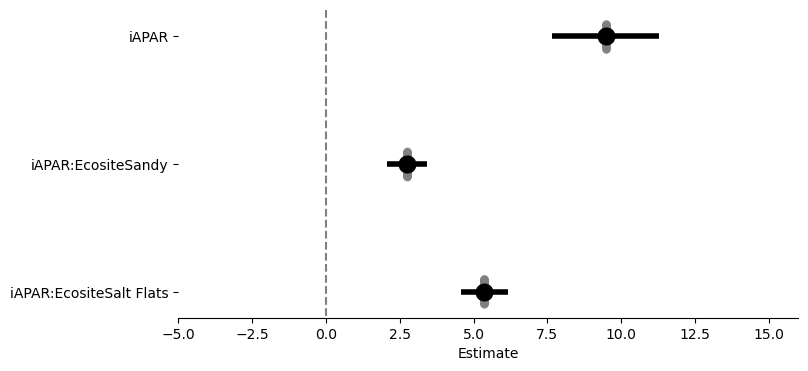

In [43]:
md_mm_ecosite = Lmer(y_var + ' ~ iAPAR + Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_ecosite.fit())
md_mm_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Treatment:iAPAR+Ecosite:iAPAR+Treatment:Ecosite:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6082.696 	 AIC: 12185.392

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  14137.924  118.903
Year        (Intercept)  54635.079  233.741
Residual                 83223.111  288.484

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),210.113,-3.490,423.716,108.983,23.214,1.928,0.066,.
iAPAR,9.053,7.194,10.912,0.948,483.949,9.545,0.000,***
iAPAR:TreatmentTGM,-0.107,-0.762,0.547,0.334,763.819,-0.321,0.748,
iAPAR:EcositeSandy,2.864,1.999,3.728,0.441,662.442,6.494,0.000,***
iAPAR:EcositeSalt Flats,4.474,3.385,5.564,0.556,833.898,8.049,0.000,***
iAPAR:TreatmentTGM:EcositeSandy,-0.257,-1.339,0.825,0.552,762.561,-0.465,0.642,
iAPAR:TreatmentTGM:EcositeSalt Flats,1.642,0.210,3.074,0.731,775.144,2.247,0.025,*


<Axes: xlabel='Estimate'>

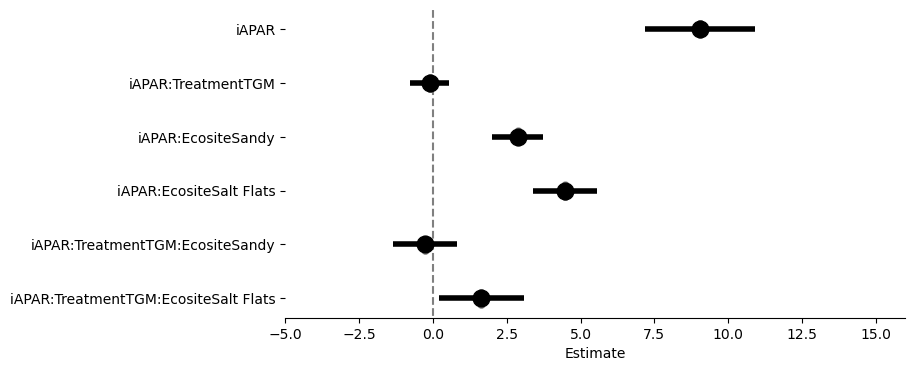

In [44]:
md_mm_treatment_ecosite = Lmer(y_var + ' ~ iAPAR + Treatment:iAPAR + Ecosite:iAPAR + Treatment:Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_treatment_ecosite.fit())
md_mm_treatment_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

Linear mixed model fit by REML [’lmerMod’]
Formula: Total_Biomass~iAPAR+Graze_timing:iAPAR+Ecosite:iAPAR+Graze_timing:Ecosite:iAPAR+(1|Year)+(1|Year:Block)

Family: gaussian	 Inference: parametric

Number of observations: 852	 Groups: {'Year:Block': 90.0, 'Year': 9.0}

Log-likelihood: -6074.015 	 AIC: 12174.030

Random effects:

                   Name        Var      Std
Year:Block  (Intercept)  13939.987  118.068
Year        (Intercept)  51641.525  227.248
Residual                 82443.164  287.129

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),191.191,-17.513,399.895,106.484,23.449,1.796,0.085,.
iAPAR,9.197,7.385,11.009,0.924,498.877,9.948,0.000,***
iAPAR:Graze_timingSeason-long,0.005,-1.498,1.508,0.767,817.240,0.007,0.994,
iAPAR:Graze_timingPulse,0.064,-0.658,0.787,0.369,828.641,0.174,0.862,
iAPAR:EcositeSandy,2.461,1.368,3.554,0.558,760.219,4.414,0.000,***
iAPAR:EcositeSalt Flats,3.540,2.168,4.913,0.700,835.047,5.056,0.000,***
iAPAR:Graze_timingSeason-long:EcositeSandy,2.043,-0.079,4.164,1.082,834.264,1.887,0.059,.
iAPAR:Graze_timingPulse:EcositeSandy,0.098,-1.199,1.395,0.662,833.739,0.148,0.882,
iAPAR:Graze_timingSeason-long:EcositeSalt Flats,2.604,-0.133,5.341,1.396,819.712,1.865,0.063,.
iAPAR:Graze_timingPulse:EcositeSalt Flats,2.445,0.832,4.058,0.823,804.096,2.971,0.003,**


<Axes: xlabel='Estimate'>

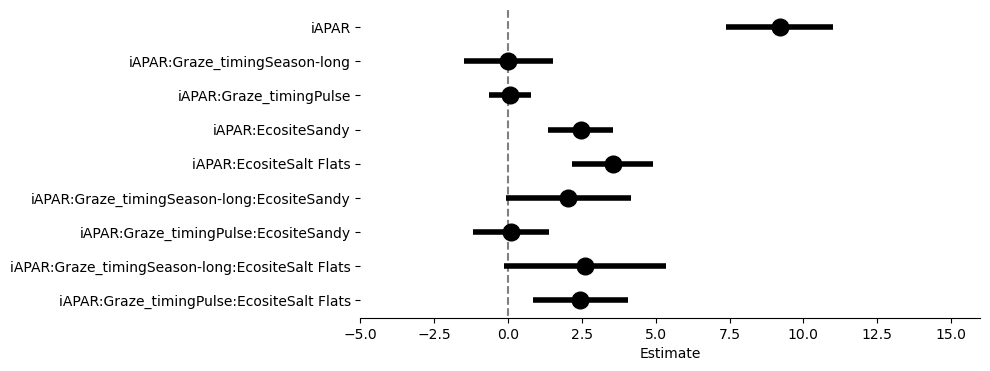

In [45]:
md_mm_graze_ecosite = Lmer(y_var + ' ~ iAPAR + Graze_timing:iAPAR + Ecosite:iAPAR + Graze_timing:Ecosite:iAPAR + (1|Year) + (1|Year:Block)', data=df_sub)
display(md_mm_graze_ecosite.fit())
md_mm_graze_ecosite.plot_summary(plot_intercept=False, figsize=(8, 4), axlim=axlims)

In [46]:
mod_dict = {
    'Null': {
        'model': md_mm_null},
    'CARM': {
        'model': md_mm_treatment},
    'Grazing': {
        'model': md_mm_graze},
    'Ecosite': {
        'model': md_mm_ecosite},
    'CARM + Ecosite': {
        'model': md_mm_treatment_ecosite},
    'Grazing + Ecosite': {
        'model': md_mm_graze_ecosite},
}

In [47]:
for mod in mod_dict:
    r2 = rsquared(mod_dict[mod]['model'].data[y_var], mod_dict[mod]['model'].residuals, has_constant=True)
    r2_adj = rsquared_adj(r2, nobs=len(mod_dict[mod]['model'].residuals), 
                          df_res=(len(mod_dict[mod]['model'].residuals) - len(mod_dict[mod]['model'].coefs)),
                          has_constant=True)
    mod_dict[mod]['R2_adj'] = r2_adj
    mod_dict[mod]['AIC'] = mod_dict[mod]['model'].AIC

In [48]:
mod_dict[mod]['model'].formula

'Total_Biomass~iAPAR+Graze_timing:iAPAR+Ecosite:iAPAR+Graze_timing:Ecosite:iAPAR+(1|Year)+(1|Year:Block)'

In [49]:
df_results = pd.DataFrame({'Model': [k for k in mod_dict.keys()],
                           'AIC': [mod_dict[k]['AIC'] for k in mod_dict.keys()],
                           'R2': [mod_dict[k]['R2_adj'] for k in mod_dict.keys()]})

In [50]:
df_results['AICd'] = df_results['AIC'] - df_results['AIC'].min()

In [51]:
df_results['AICw'] = np.exp( -0.5 * df_results['AICd'])

In [52]:
df_results['formula'] = df_results['Model'].transform(lambda x: mod_dict[x]['model'].formula)

In [53]:
with pd.option_context('display.max_colwidth', 500):
    display(df_results.sort_values('AICd'))

,Model,AIC,R2,AICd,AICw,formula
5,Grazing + Ecosite,12174.029902,0.774827,0.000000,1.000000e+00,Total_Biomass~iAPAR+Graze_timing:iAPAR+Ecosite:iAPAR+Graze_timing:Ecosite:iAPAR+(1|Year)+(1|Year:Block)
4,CARM + Ecosite,12185.392224,0.772741,11.362321,3.409599e-03,Total_Biomass~iAPAR+Treatment:iAPAR+Ecosite:iAPAR+Treatment:Ecosite:iAPAR+(1|Year)+(1|Year:Block)
3,Ecosite,12186.781608,0.771097,12.751705,1.702168e-03,Total_Biomass~iAPAR+Ecosite:iAPAR+(1|Year)+(1|Year:Block)
2,Grazing,12311.493311,0.756572,137.463408,1.413189e-30,Total_Biomass~iAPAR+Graze_timing:iAPAR+(1|Year)+(1|Year:Block)
0,Null,12318.020862,0.755462,143.990960,5.404561e-32,Total_Biomass~iAPAR+(1|Year)+(1|Year:Block)
1,CARM,12319.508028,0.755529,145.478125,2.569369e-32,Total_Biomass~iAPAR+Treatment:iAPAR+(1|Year)+(1|Year:Block)


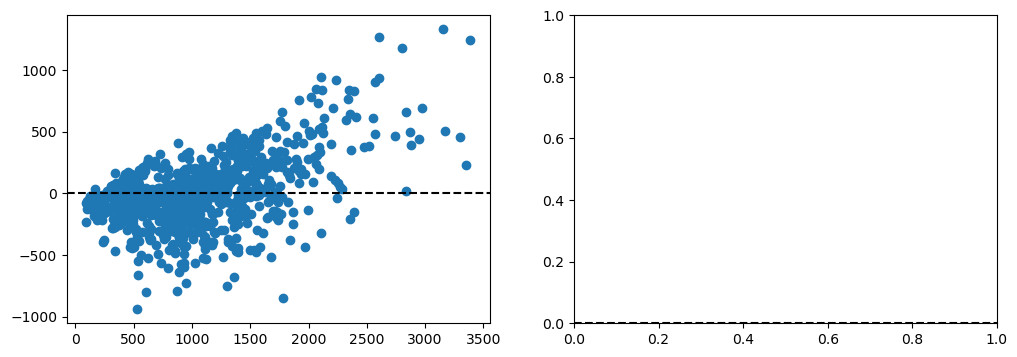

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], md_mm_graze_ecosite.residuals)
#axs[1].scatter(df_sub['Total_Biomass_sqrt'], md_mm_sqrt.residuals)
for ax in axs:
    ax.axhline(y=0, linestyle='dashed', c='black')

(array([  8.,  25.,  99., 201., 257., 151.,  76.,  25.,   6.,   4.]),
 array([-12.2179861 ,  -9.43346595,  -6.64894579,  -3.86442564,
         -1.07990549,   1.70461467,   4.48913482,   7.27365497,
         10.05817513,  12.84269528,  15.62721543]),
 <BarContainer object of 10 artists>)

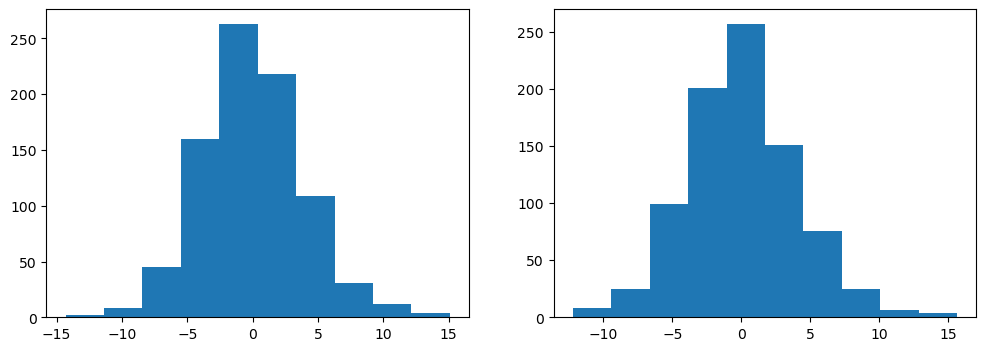

In [225]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].hist(md_mm_ecosite.residuals)
axs[1].hist(md_mm_sqrt.residuals)

In [ ]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
probplot(md_mm_ecosite.residuals, dist="norm", plot=axs[0])
axs[0].text(-3, 500, 'Shapiro: ' + str(round(shapiro(md_mm_ecosite.residuals).statistic, 2)))
probplot(md_mm_sqrt.residuals, dist="norm", plot=axs[1])
axs[1].text(-3, 5, 'Shapiro: ' + str(round(shapiro(md_mm_sqrt.residuals).statistic, 2)))
plt.show()

In [55]:
coefs_fnl = md_mm_graze_ecosite.coefs.reset_index().rename(columns={'index': 'Coef'})
coefs_fnl['Coef'] = coefs_fnl['Coef'].apply(lambda x: re.sub('Ecosite', '', 
                                         re.sub('Graze_timing', '', x)))
coefs_fnl = coefs_fnl[coefs_fnl['Coef'] != '(Intercept)']
colors = coefs_fnl.apply(lambda x: 'grey' if x['Sig'] == '' else 'black', axis=1).astype(str).values

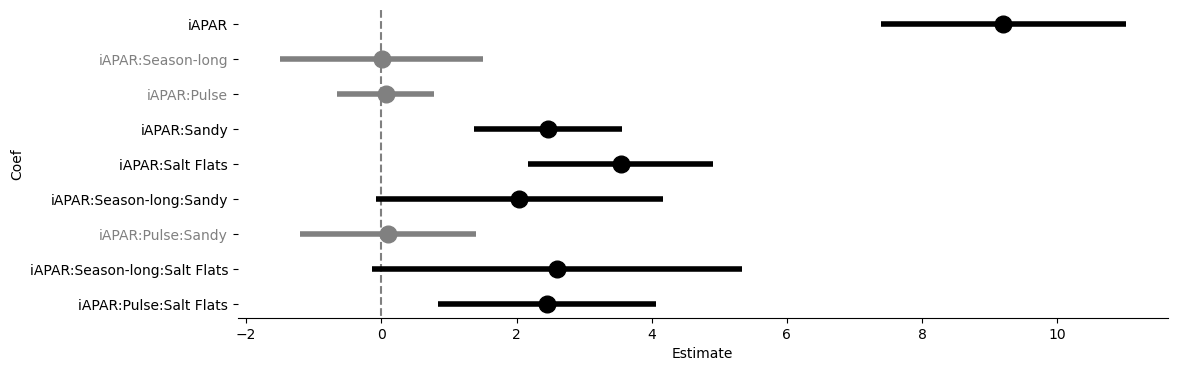

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
col_lb = (coefs_fnl["Estimate"] - coefs_fnl["2.5_ci"]).values
col_ub = (coefs_fnl["97.5_ci"] - coefs_fnl["Estimate"]).values

x_strip = "Estimate"
x_err = coefs_fnl["Estimate"]
y_strip = "Coef"
y_err = np.array([x for x in range(len(coefs_fnl))])
xerr = [col_lb, col_ub]
yerr = None
ax.vlines(
    x=0, ymin=-1, ymax=len(coefs_fnl), linestyles="--", color="grey"
)
xlim = (-5.0, 13)
ylim = None
sns.stripplot(
            x=x_strip, y=y_strip, data=coefs_fnl, ax=ax, size=6, alpha=0, color="grey"
        )
for c in np.unique(colors):
    ax.errorbar(
                x=x_err[colors == c],
                y=y_err[colors == c],
                xerr=[col_lb[colors == c], col_ub[colors == c]],
                yerr=yerr,
                fmt="o",
                capsize=0,
                elinewidth=4,
                color=c,
                ms=12,
                zorder=9999999999,
            )
    [ax.get_yticklabels()[i].set_color(c) for i, color in enumerate(colors) if color == c]
    #ax.get_yticklabels()[colors == c].set_color("red")
sns.despine(top=True, right=True, left=True)

/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

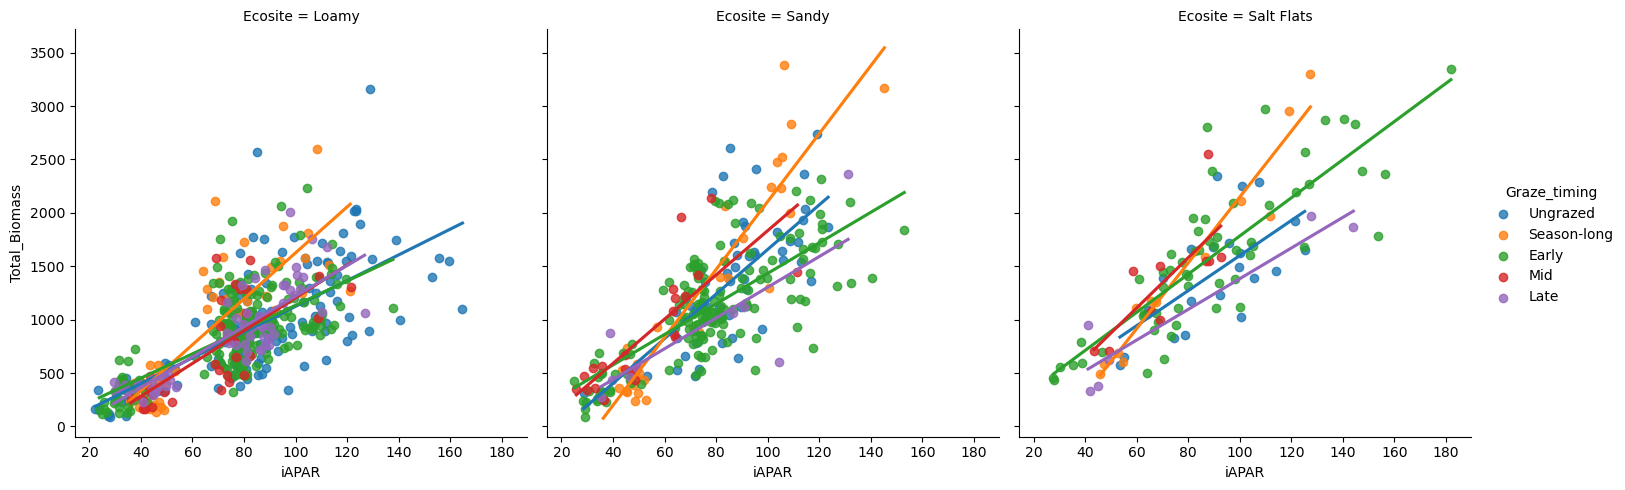

In [227]:
plt.figure()
sns.lmplot(x='iAPAR', y='Total_Biomass', hue='Graze_timing', col='Ecosite', ci=None, 
           data=df_sub)
plt.show()

In [207]:
df['pred_biomass'] = md_mm_graze_ecosite.predict(df, skip_data_checks=True, use_rfx=True, verify_predictions=False)
df['pred_biomass_no_rf'] = md_mm_graze_ecosite.predict(df, skip_data_checks=True, use_rfx=False, verify_predictions=False)
df['resid_biomass'] = df['Total_Biomass'] - df['pred_biomass']
df['resid_biomass_no_rf'] = df['Total_Biomass'] - df['pred_biomass_no_rf']

/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


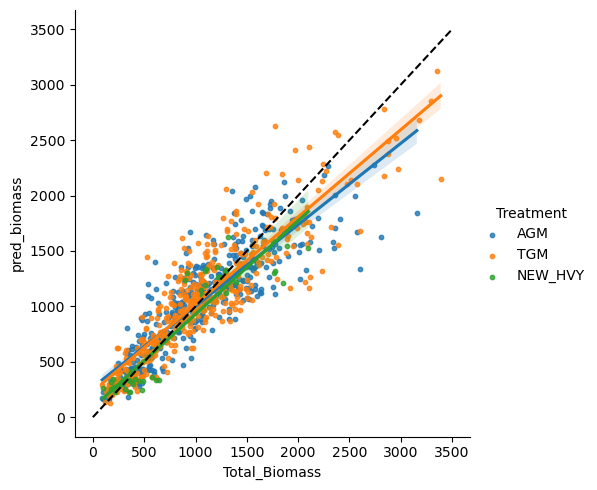

In [167]:
p = sns.lmplot(x='Total_Biomass', y='pred_biomass', hue='Treatment', data=df,
            scatter_kws=dict(s=10))
p.ax.plot(np.arange(0, 3500), np.arange(0, 3500), c='black', linestyle='dashed')

/home/spkearney/miniconda3/envs/pymer4/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


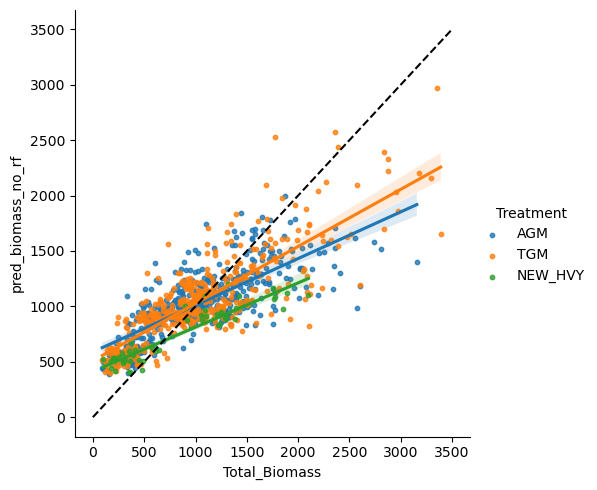

In [168]:
p = sns.lmplot(x='Total_Biomass', y='pred_biomass_no_rf', hue='Treatment', data=df,
            scatter_kws=dict(s=10))
p.ax.plot(np.arange(0, 3500), np.arange(0, 3500), c='black', linestyle='dashed')

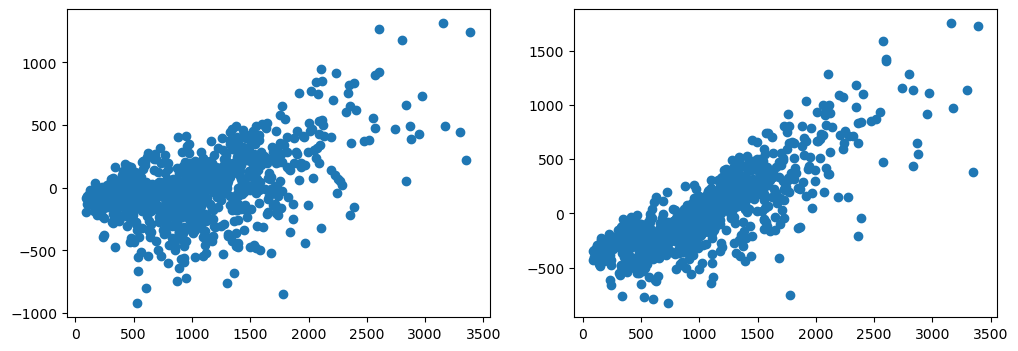

In [208]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].scatter(df_sub['Total_Biomass'], df['resid_biomass'][df['Treatment'].isin(['AGM', 'TGM'])])
axs[1].scatter(df_sub['Total_Biomass'], df['resid_biomass_no_rf'][df['Treatment'].isin(['AGM', 'TGM'])])